In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import time
import os
from matplotlib import cm
from scipy.linalg import eig
from sklearn.linear_model import Lasso

In [2]:
import warnings
warnings.filterwarnings('ignore')

# function for solving estimated master equations

In [3]:
def get_frac_from_infl(t, a_k_vector, p=0.05):
    ''' input:
        t - vector of time, has to be column vector
        a_k_vector - values of influence we got from the simulations
    output:
        values of solution of collapsed master equations for provided vector of time stamps
        '''
    #create a matrix for system of ODEs
    C = np.zeros((len(a_k_vector)+1,len(a_k_vector)+1))
    np.fill_diagonal(C, [-n*p-a_k for n, a_k in enumerate(np.concatenate((a_k_vector, np.zeros(1))), 1)])
    C = np.concatenate((np.zeros((1, len(a_k_vector)+1)), C))
    np.fill_diagonal(C, [a_k for a_k in np.concatenate((np.zeros(1), a_k_vector))])
    C = C[1:]
    w, V = eig(C)  
    LR = Lasso(fit_intercept=False, alpha=10**(-4))
    LR.fit(V, np.ones(len(C)))
    c = LR.coef_.reshape(1,-1)   
    v = V[0].reshape(1,-1)
    w = w.real.reshape(1,-1)
    # construct solution
    first_row = v*c*np.exp(t*w)
    frac = 1-first_row.sum(1)
    return frac

# compare solutions of estimated master equations to simulations

In [4]:
evenly_spaced_interval = np.linspace(0, 1, 40)
green_colors = [cm.Greens(x) for x in evenly_spaced_interval][::-1]
purple_colors = [cm.Purples(x) for x in evenly_spaced_interval][::-1]
blue_colors = [cm.Blues(x) for x in evenly_spaced_interval][::-1]

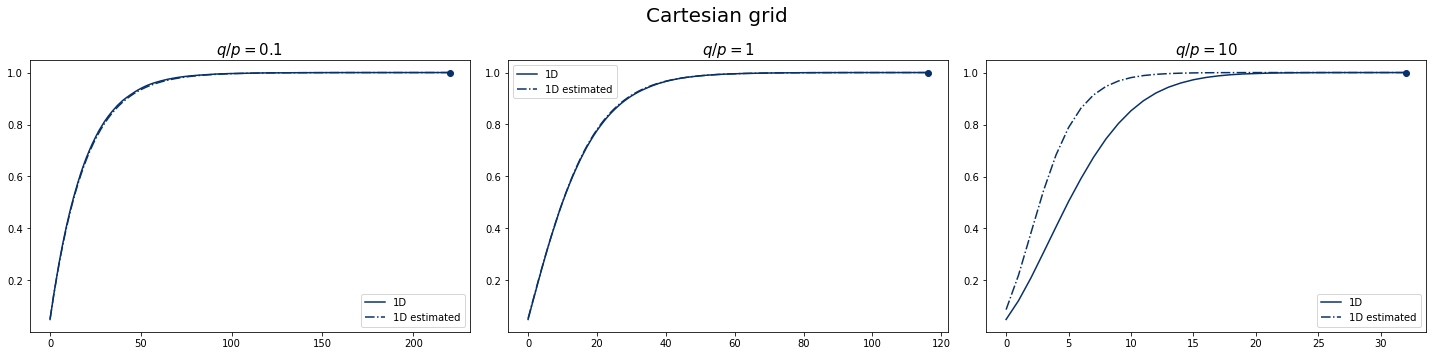

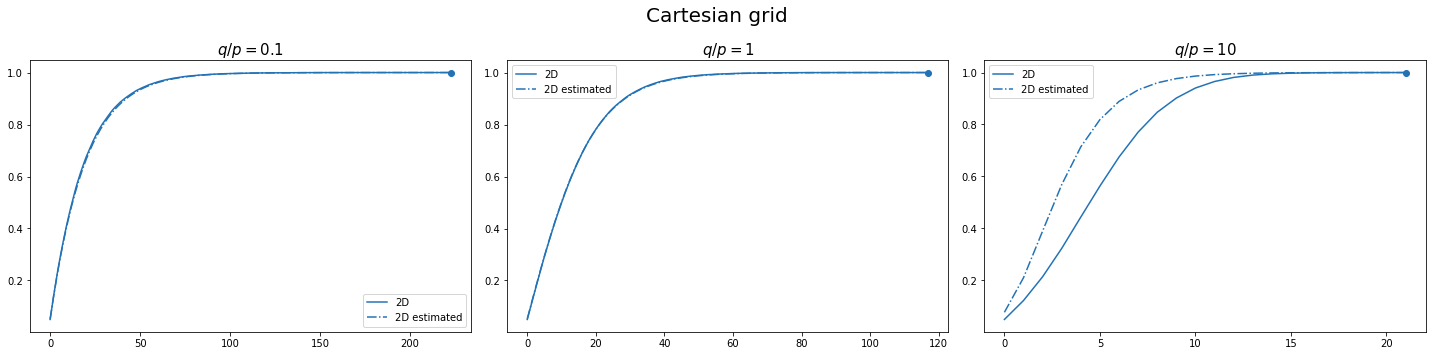

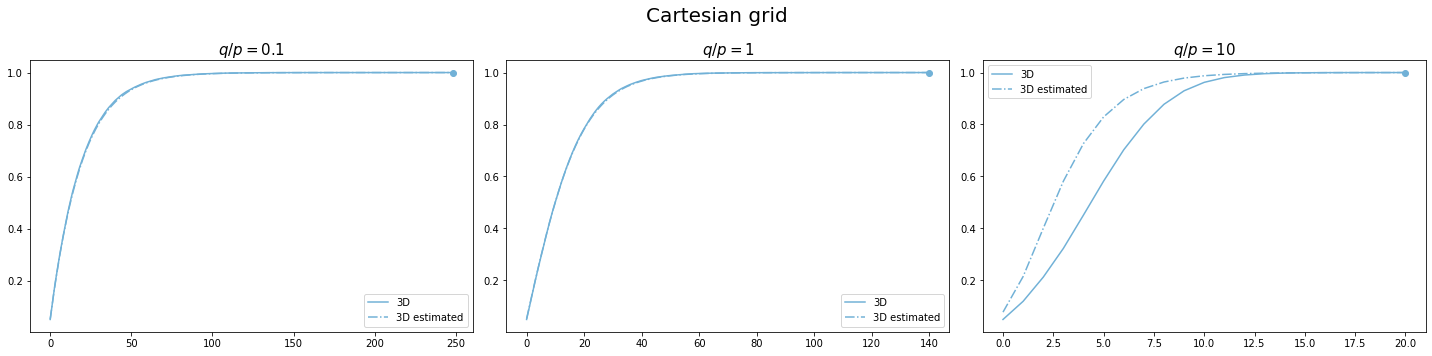

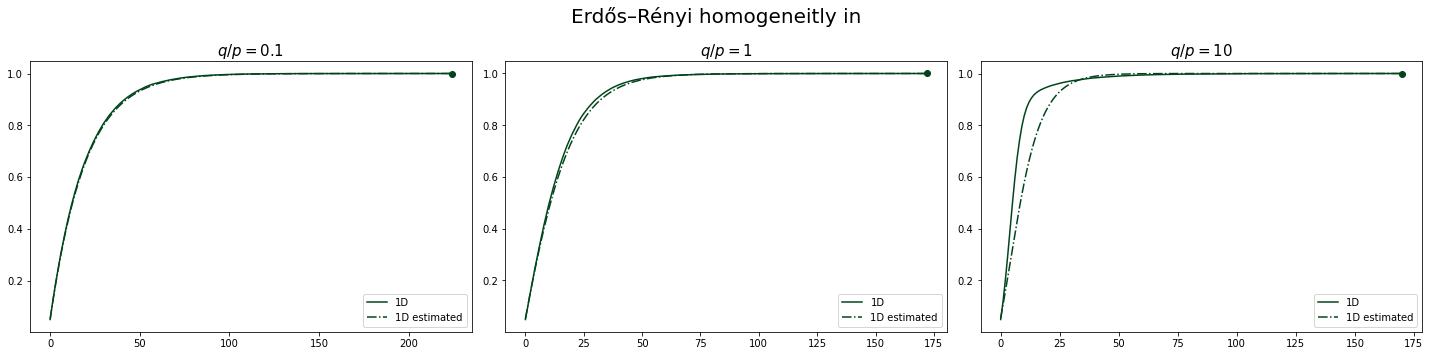

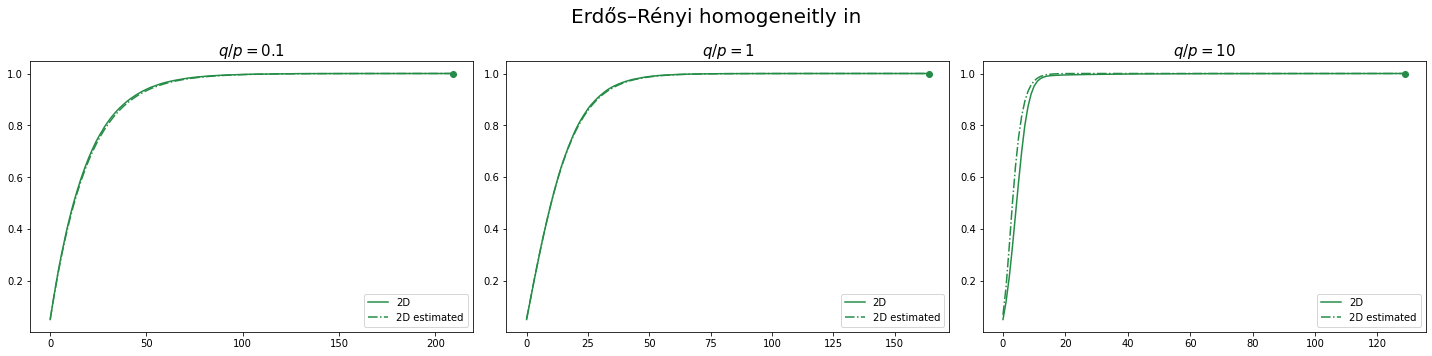

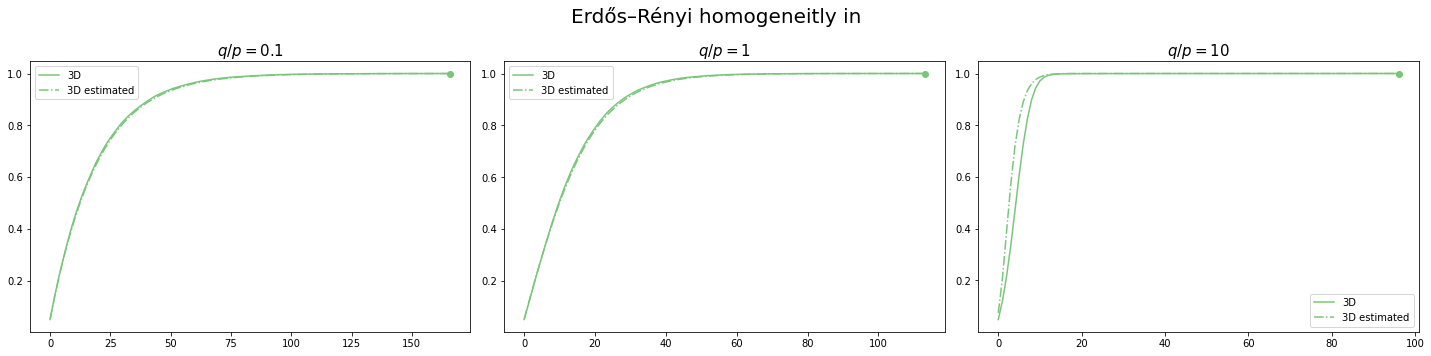

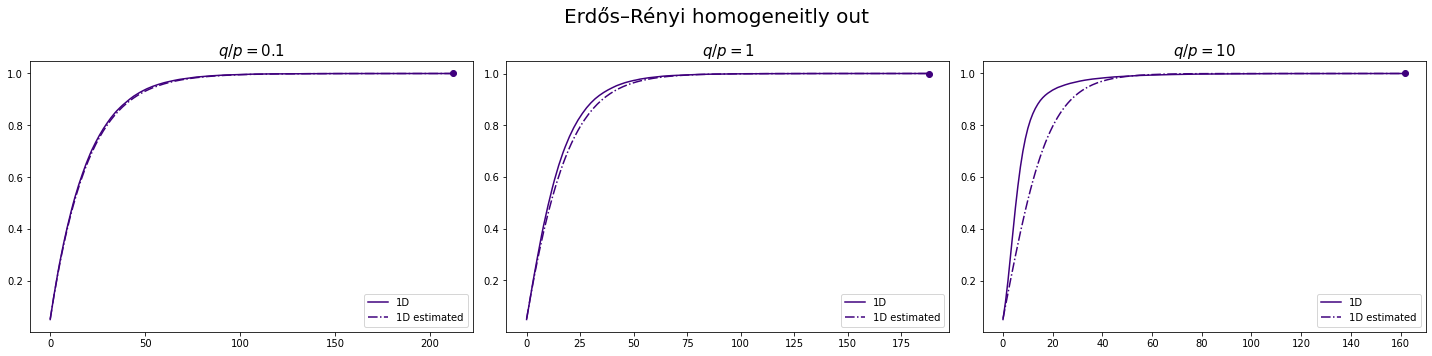

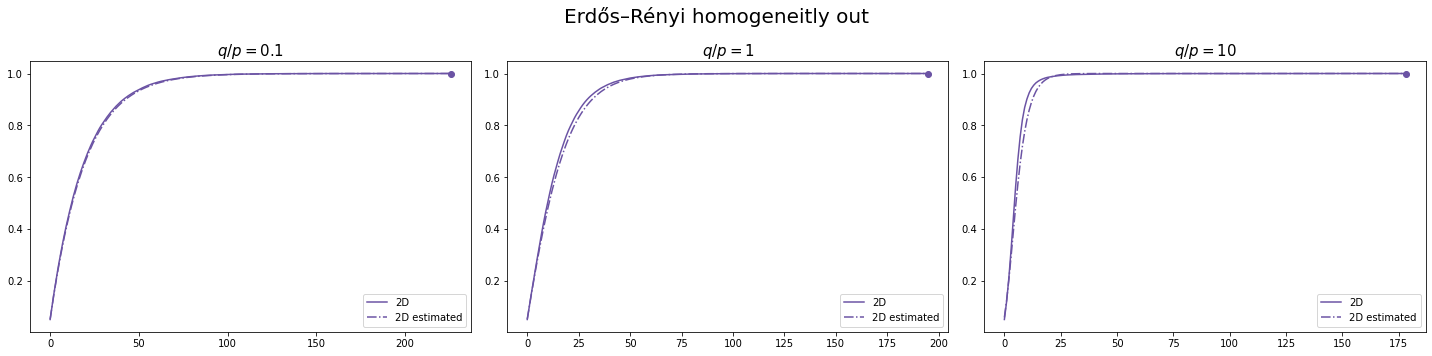

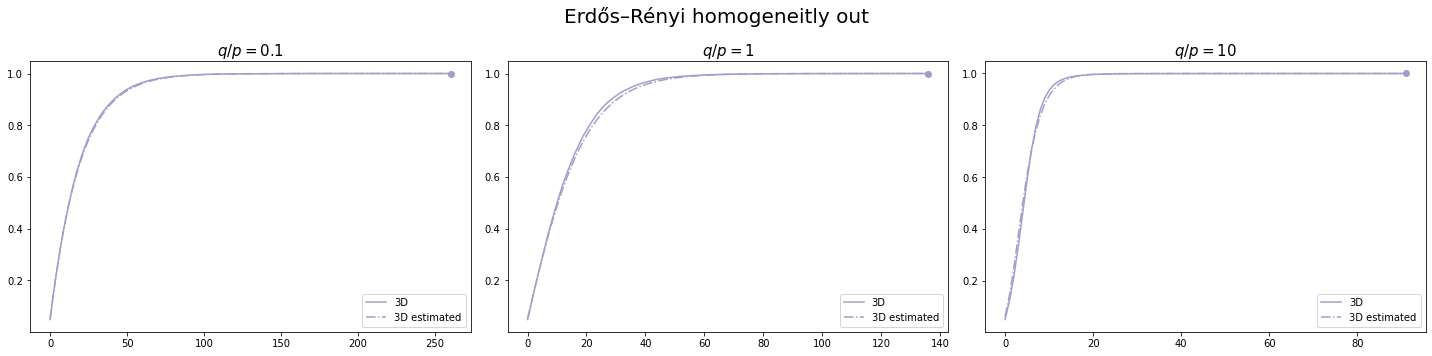

In [5]:
for hom in ['in', 'out']:

    for which in ['CART', 'ER']:
        if which=='CART' and hom=='out':
            continue
        else:
            
            for D in [1, 2, 3]:
                plt.figure(figsize=(20,5))

                frac_dict = pickle.load(open(f'simulations/frac_M100_nsim1000/{which}_{D}D_{hom}', 'rb'))
                a_vector_dict = pickle.load(open(f'simulations/ME_M30_nsim10000/ME_{which}_{D}D_{hom}', 'rb'))

                for i, r in enumerate(frac_dict.keys()):
                    plt.subplot(1, 3,i+1)

                    frac = frac_dict[r]
                    frac = frac[frac!=1]

                    if hom=='in' and which=='ER':
                        colors = green_colors
                    elif hom=='out' and which=='ER':
                        colors = purple_colors
                    elif which=='CART':
                        colors = blue_colors
                    
                    T = np.arange(1, len(frac)+1).reshape(-1,1)

                    a_vector = a_vector_dict[r][1:-1][::-1]
                    frac_ME = get_frac_from_infl(T, a_vector)
                    
                    plt.plot(frac, c=colors[10*(D-1)], label=f'{D}D')
                    plt.plot(frac.shape[0]-1, 1, c=colors[10*(D-1)], marker='o')
                    plt.plot(frac_ME, c=colors[10*(D-1)], ls='-.', label=f'{D}D estimated')
                    plt.legend()
                    plt.title('$q/p=$'+str(r), fontsize=15) 
                if which=='ER':
                    plt.suptitle(f'Erdős–Rényi homogeneitly {hom}', fontsize=20) 
                if which=='CART':
                    plt.suptitle('Cartesian grid', fontsize=20) 
                plt.tight_layout()
                plt.savefig(f'simulations_plot/ME_{which}_{D}D_{hom}')
            plt.show()


# magnitude of difference between different dimentions

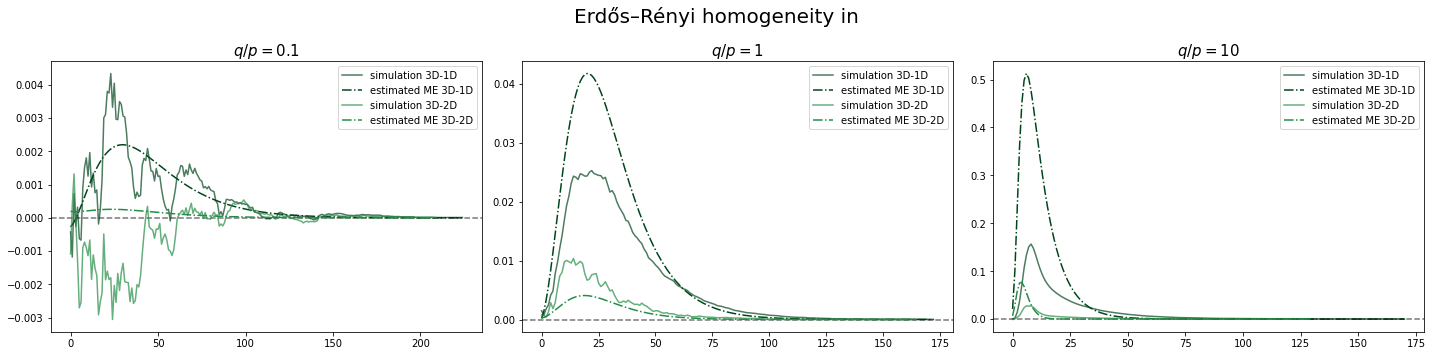

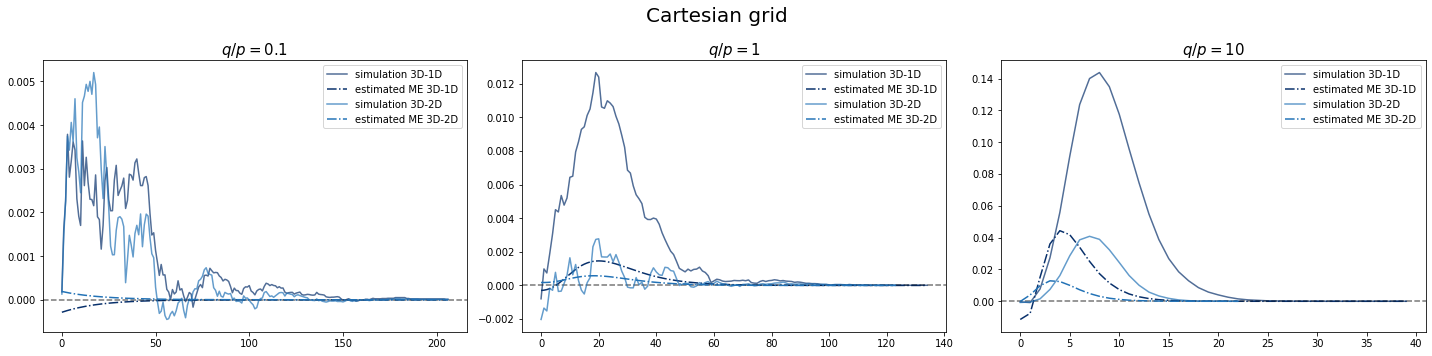

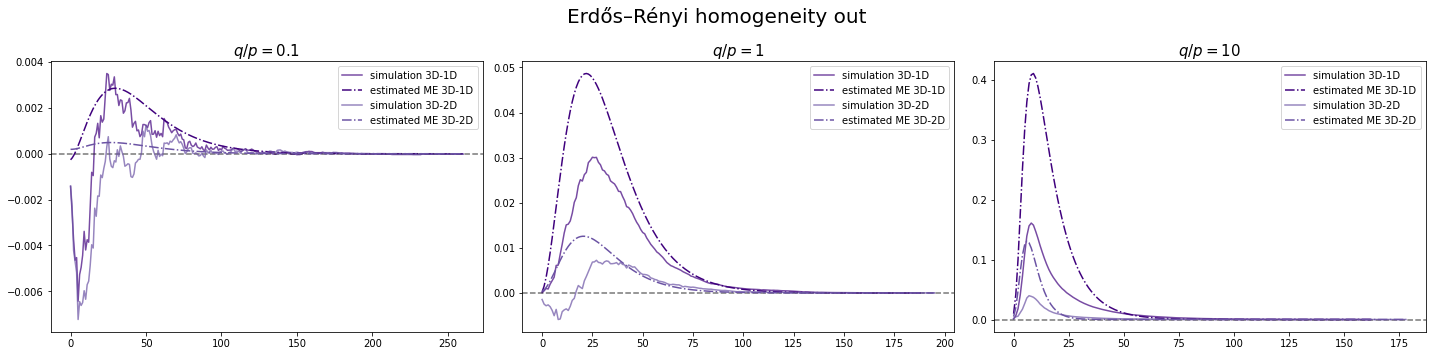

In [6]:
for hom in ['in', 'out']:
    

    for which in ['CART', 'ER']:
        if which=='CART' and hom=='in':
            continue
        else:
            plt.figure(figsize=(20,5))
            for D in [1, 2]:
                
                frac_dict3D = pickle.load(open(f'simulations/frac_M100_nsim1000/{which}_3D_{hom}', 'rb'))
                frac_dict = pickle.load(open(f'simulations/frac_M100_nsim1000/{which}_{D}D_{hom}', 'rb'))
                
                a_vector_dict3D = pickle.load(open(f'simulations/ME_M30_nsim10000/ME_{which}_3D_{hom}', 'rb'))
                a_vector_dict = pickle.load(open(f'simulations/ME_M30_nsim10000/ME_{which}_{D}D_{hom}', 'rb'))
                

                for i, r in enumerate(frac_dict.keys()):
                    plt.subplot(1, 3,i+1)

                    frac3D = frac_dict3D[r]
                    frac = frac_dict[r]
                    diff = frac3D-frac
                    diff = diff[diff!=0]
                    
                    T = np.arange(1, len(diff)+1).reshape(-1,1)
      
                    a_vector_3D = a_vector_dict3D[r][1:-1][::-1]
                    frac_ME_3D = get_frac_from_infl(T, a_vector_3D)

                    a_vector = a_vector_dict[r][1:-1][::-1]
                    frac_ME = get_frac_from_infl(T, a_vector)

                    diff_ME = frac_ME_3D-frac_ME
            

                    if hom=='in' and which=='ER':
                        colors = green_colors
                    elif hom=='out' and which=='ER':
                        colors = purple_colors
                    elif which=='CART':
                        colors = blue_colors
                    plt.axhline(0, ls = '--', c='k', alpha=0.3)
                    plt.plot(diff, c=colors[10*(D-1)], label=f'simulation 3D-{D}D', alpha=0.7)
                    plt.plot(diff_ME, c=colors[10*(D-1)], label=f'estimated ME 3D-{D}D', ls='-.')
                    plt.legend()
                    plt.title('$q/p=$'+str(r), fontsize=15) 
                if which=='ER':
                    plt.suptitle(f'Erdős–Rényi homogeneity {hom}', fontsize=20) 
                if which=='CART':
                    plt.suptitle('Cartesian grid', fontsize=20) 
                plt.tight_layout()
                plt.savefig(f'simulations_plot/diff_{which}_{hom}')
        plt.show()

# magnitude of difference between Cartesian grid and random graph

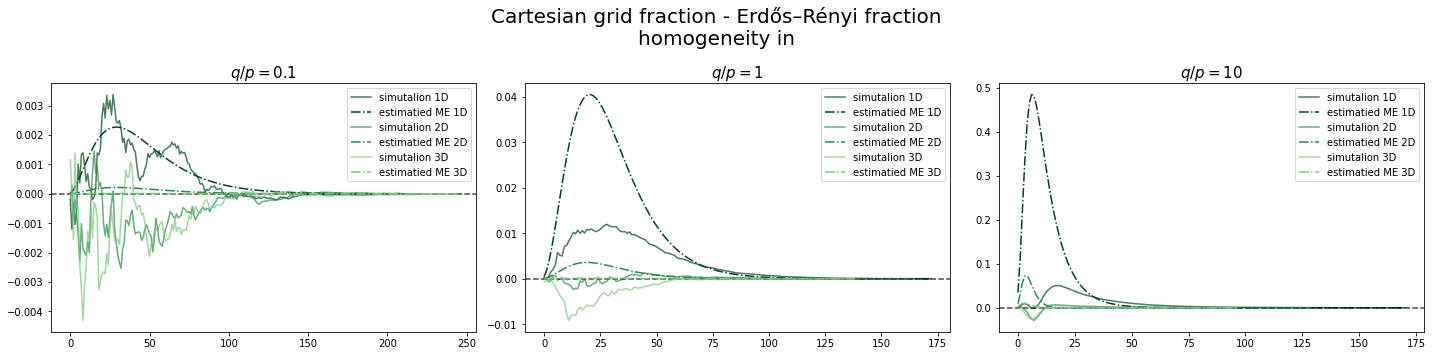

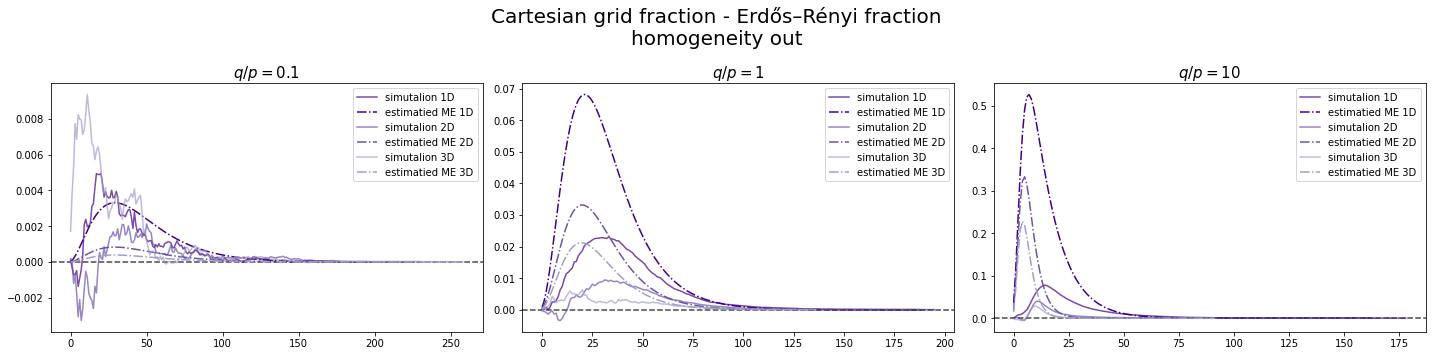

In [7]:

for hom in ['in', 'out']:    
    plt.figure(figsize=(20,5))
    for D in [1,2,3]:
        
        frac_dict_CART = pickle.load(open(f'simulations/frac_M100_nsim1000/CART_{D}D_{hom}', 'rb'))
        frac_dict_ER = pickle.load(open(f'simulations/frac_M100_nsim1000/ER_{D}D_{hom}', 'rb'))

        a_vector_dict_CART = pickle.load(open(f'simulations/ME_M30_nsim10000/ME_CART_{D}D_{hom}', 'rb'))
        a_vector_dict_ER = pickle.load(open(f'simulations/ME_M30_nsim10000/ME_ER_{D}D_{hom}', 'rb'))
        
        for i, r in enumerate(frac_dict.keys()):
            plt.subplot(1, 3,i+1)

            frac_CART = frac_dict_CART[r]
            frac_ER = frac_dict_ER[r]
            diff = frac_CART-frac_ER
            diff = diff[diff!=0]

            T = np.arange(1, len(diff)+1).reshape(-1,1)
      
            a_vector_CART = a_vector_dict_CART[r][1:-1][::-1]
            frac_ME_CART = get_frac_from_infl(T, a_vector_CART)

            a_vector_ER = a_vector_dict_ER[r][1:-1][::-1]
            frac_ME_ER = get_frac_from_infl(T, a_vector_ER)
            
            diff_ME = frac_ME_CART-frac_ME_ER
            
            if hom=='in':
                colors = green_colors
            elif hom=='out':
                colors = purple_colors

            plt.axhline(0, ls = '--', c='k', alpha=0.3)
            plt.plot(diff, c=colors[(D-1)*10], label=f'simutalion {D}D', alpha=0.7)
            plt.plot(diff_ME, c=colors[(D-1)*10], label=f'estimatied ME {D}D', ls='-.')
            plt.legend()
            plt.title('$q/p=$'+str(r), fontsize=15) 

        plt.suptitle(f'Cartesian grid fraction - Erdős–Rényi fraction\nhomogeneity {hom}', fontsize=20) 
        plt.tight_layout()
        plt.savefig(f'simulations_plot/diff_{hom}')
    plt.show()

# magnitude of difference between homogeneity 'in' and 'out'

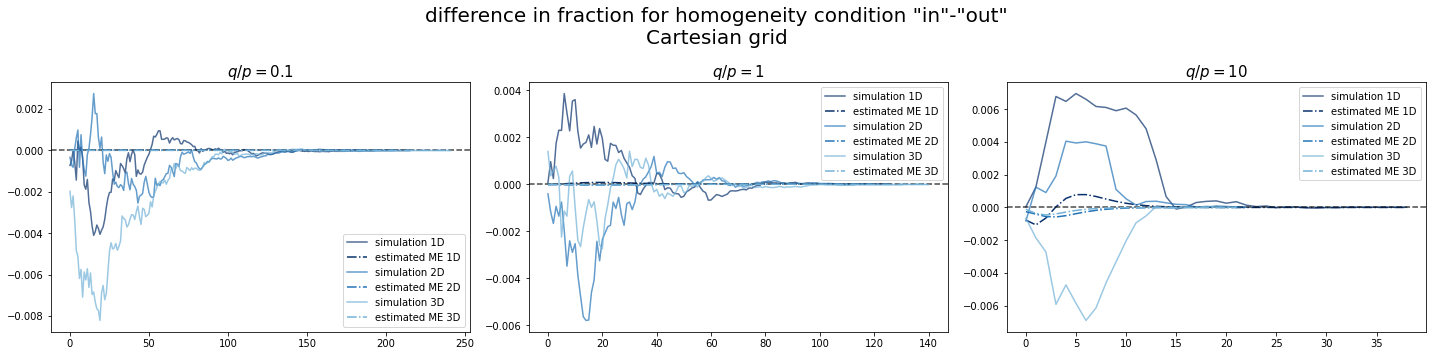

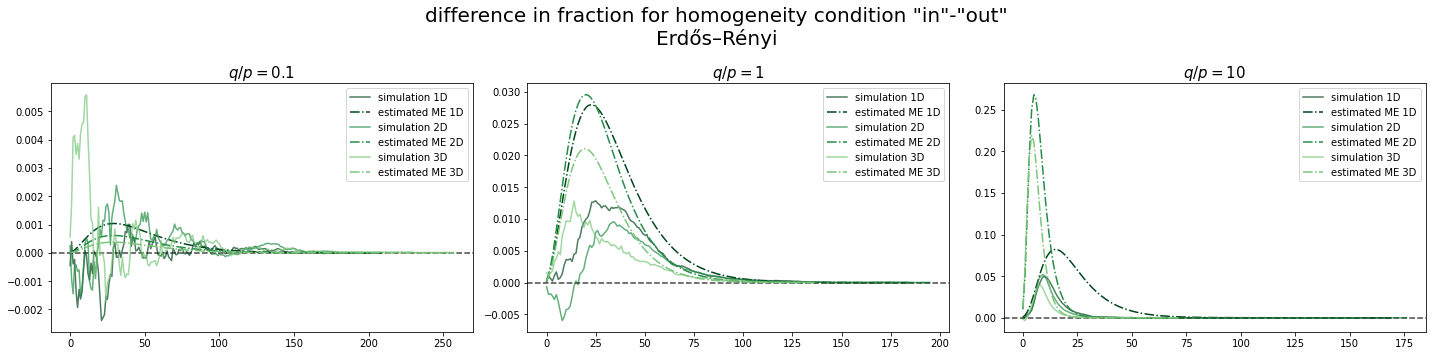

In [8]:
for which in ['CART', 'ER']:

    plt.figure(figsize=(20,5))
    for D in [1, 2, 3]:


        frac_dict_in = pickle.load(open(f'simulations/frac_M100_nsim1000/{which}_{D}D_in', 'rb'))
        frac_dict_out = pickle.load(open(f'simulations/frac_M100_nsim1000/{which}_{D}D_out', 'rb'))
        a_vector_dict_in = pickle.load(open(f'simulations/ME_M30_nsim10000/ME_{which}_{D}D_in', 'rb'))
        a_vector_dict_out = pickle.load(open(f'simulations/ME_M30_nsim10000/ME_{which}_{D}D_out', 'rb'))

        for i, r in enumerate(frac_dict.keys()):
            plt.subplot(1, 3,i+1)

            frac_in = frac_dict_in[r]
            frac_out = frac_dict_out[r]
            diff_sim = frac_in-frac_out
            diff_sim = diff_sim[diff_sim!=0]

            T = np.arange(1, len(diff_sim)+1).reshape(-1,1)
      
            a_vector_in = a_vector_dict_in[r][1:-1][::-1]
            frac_ME_in = get_frac_from_infl(T, a_vector_in)

            a_vector_out = a_vector_dict_out[r][1:-1][::-1]
            frac_ME_out = get_frac_from_infl(T, a_vector_out)
            diff_ME = frac_ME_in-frac_ME_out
            diff_ME = diff_ME[diff_ME!=0]
            
            if which=='ER':
                colors = green_colors
            elif which=='CART':
                colors = blue_colors
            plt.axhline(0, ls = '--', c='k', alpha=0.3)
            plt.plot(diff_sim, c=colors[10*(D-1)], label=f'simulation {D}D', alpha=0.7)
            plt.plot(diff_ME, c=colors[10*(D-1)], label=f'estimated ME {D}D', ls='-.')
            plt.legend()
            plt.title('$q/p=$'+str(r), fontsize=15) 
        if which=='ER':
            plt.suptitle(f'difference in fraction for homogeneity condition "in"-"out"\nErdős–Rényi', fontsize=20) 
        if which=='CART':
            plt.suptitle('difference in fraction for homogeneity condition "in"-"out"\nCartesian grid', fontsize=20) 
        plt.tight_layout()
        plt.savefig(f'simulations_plot/diff_{which}')
    plt.show()

# all fractions plots

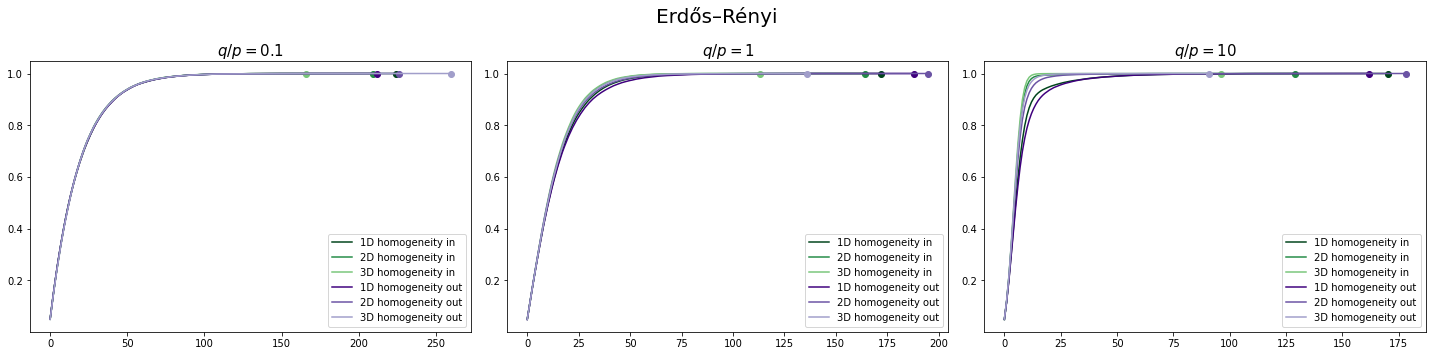

In [9]:
plt.figure(figsize=(20,5))
for hom in ['in', 'out']:

    for D in [1, 2, 3]:
        frac_dict_ER = pickle.load(open(f'simulations/frac_M100_nsim1000/ER_{D}D_{hom}', 'rb'))
        for i, r in enumerate(frac_dict_ER.keys()):
            plt.subplot(1, 3,i+1)
            A = frac_dict_ER[r]
            frac_ER = A[(A!=1)]
            if hom=='in':
                colors = green_colors
            else:
                colors = purple_colors
    
            plt.plot(frac_ER, c=colors[(D-1)*10], label=f'{D}D homogeneity {hom}')
            plt.plot(frac_ER.shape[0]-1, 1, c=colors[10*(D-1)], marker='o')
            plt.legend()
            plt.title('$q/p=$'+str(r), fontsize=15)       
plt.suptitle(f'Erdős–Rényi', fontsize=20) 
plt.tight_layout()
plt.savefig(f'simulations_plot/all_ER')
plt.show()

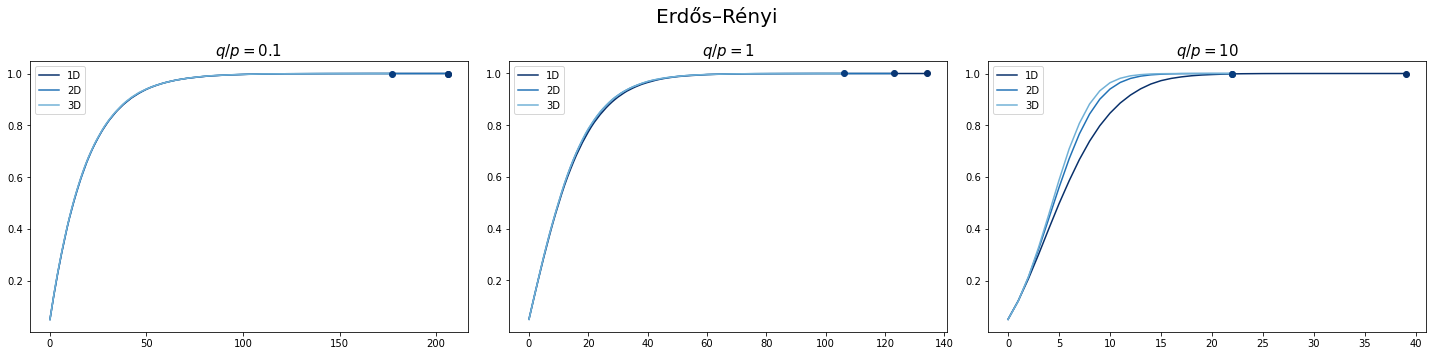

In [10]:
plt.figure(figsize=(20,5))
    
for D in [1, 2, 3]:
    frac_dict_ER = pickle.load(open(f'simulations/frac_M100_nsim1000/CART_{D}D_{hom}', 'rb'))
    for i, r in enumerate(frac_dict_ER.keys()):
        plt.subplot(1, 3,i+1)
        A = frac_dict_ER[r]
        frac_ER = A[(A!=1)]
        colors = blue_colors

        plt.plot(frac_ER, c=colors[10*(D-1)], label=f'{D}D')
        plt.plot(frac_ER.shape[0]-1, 1, c=colors[D-1], marker='o')
        plt.legend()
        plt.title('$q/p=$'+str(r), fontsize=15)       
plt.suptitle(f'Erdős–Rényi', fontsize=20) 
plt.tight_layout()
plt.savefig(f'simulations_plot/all_CART')
plt.show()